In [5]:
if "google.colab" in str(get_ipython()):
    from google.colab import drive
    import os
    drive.mount("/content/gdrive")
    os.chdir("/content/gdrive/My Drive/CS4243 Project/temp")
    !pwd
    %pip install -q ipywidgets
    %pip install -q -r requirements_colab.txt
else:
    %pip install -q -r requirements.txt

# may need to restart the kernel after installing new packages

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1uIa2T3wOAuCn9DUs8-3zctPi-lcbXpfM/CS4243 Project/temp


# Improved Model (EfficientNet-B0)

In [1]:
import torch
import torch.nn as nn

import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from utils import load_tensor

train_x, train_y = load_tensor("balan", "64", device)
test_x, test_y = load_tensor("test", "64", device)

train_x.size(), train_y.size(), test_x.size(), test_y.size()

(torch.Size([19509, 3, 64, 64]),
 torch.Size([19509]),
 torch.Size([612, 3, 64, 64]),
 torch.Size([612]))

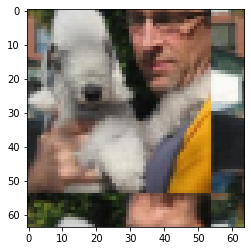

In [5]:
from utils import render_2d

idx = np.random.choice(train_x.size(0))
render_2d(train_x.cpu()[idx])

## Build CNN

A baseline EfficientNet architecture

In [3]:
from torchvision import models, transforms

class EfficientNet(nn.Module):
    def __init__(self):
        super(EfficientNet, self).__init__()
        self.layers = nn.Sequential(
            # see https://pytorch.org/vision/stable/models.html for normalisation
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            models.efficientnet_b0(pretrained=True).train(),
            nn.ReLU(),
            nn.Linear(1000, 10)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [6]:
from utils import count_num_params

net = EfficientNet()
print(f"{count_num_params(net):,}")
net

5,298,558


EfficientNet(
  (layers): Sequential(
    (0): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    (1): EfficientNet(
      (features): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              

### Training (with augmented dataset, size 64x64)

In [8]:
from utils import plot_experiments, run_experiments, save_results

def init_func():
    net = EfficientNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

    return (net, criterion, optimizer)

df_balan_64 = run_experiments(init_func, (train_x, train_y), (test_x, test_y), (3, 64, 64), batch_size=25, num_experiments=1)
save_results(df_balan_64, "efficientnet", "balan", "64")

  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 0 (06ef19e9):
epoch = 0	 loss = 1.879	 accuracy = 0.344	 test accuracy = 0.415
epoch = 10	 loss = 0.183	 accuracy = 0.939	 test accuracy = 0.622
epoch = 20	 loss = 0.069	 accuracy = 0.977	 test accuracy = 0.628


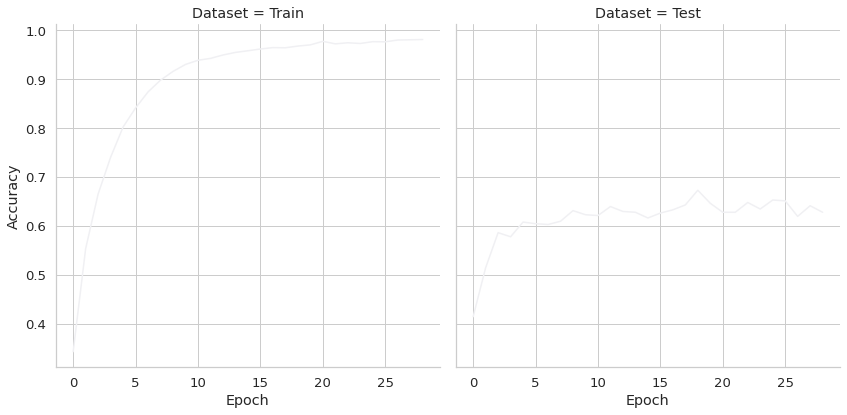

In [9]:
plot_experiments(df_balan_64)

F1 Score : 0.6713277914301057
Precision: 0.674317148251807
Recall   : 0.6774082242434553


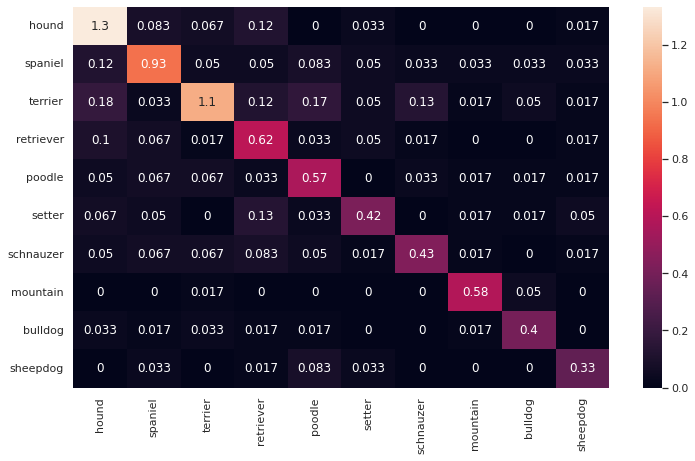

In [10]:
from utils import load_checkpoint, eval_test_accuracy, show_confusion_matrix, show_eval_metrics

net = EfficientNet().to(device)
load_checkpoint(net, "06ef19e9") # to be manually updated

mean, std = train_x.mean(), train_x.std()
accuracy, pred_y, true_y = eval_test_accuracy(net, mean, std, (test_x, test_y), (3, 64, 64), batch_size=25)

show_confusion_matrix(pred_y, true_y)
show_eval_metrics(pred_y, true_y)

### Training (with augmented dataset, size 128x128)

In [7]:
from utils import load_tensor

train_x, train_y = load_tensor("balan", "128", device)
test_x, test_y = load_tensor("test", "128", device)
train_x.size(), train_y.size(), test_x.size(), test_y.size()

(torch.Size([19487, 3, 128, 128]),
 torch.Size([19487]),
 torch.Size([612, 3, 128, 128]),
 torch.Size([612]))

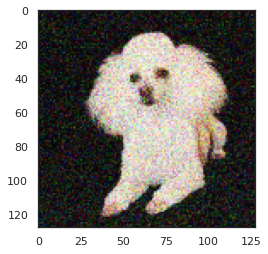

In [12]:
from utils import render_2d

idx = np.random.choice(train_x.size(0))
render_2d(train_x.cpu()[idx])

In [13]:
from utils import plot_experiments, run_experiments, save_results

def init_func():
    net = EfficientNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

    return (net, criterion, optimizer)

df_balan_128 = run_experiments(init_func, (train_x, train_y), (test_x, test_y), (3, 128, 128), batch_size=25, num_experiments=1)
save_results(df_balan_128, "efficientnet", "balan", "128")

  0%|          | 0/100 [00:00<?, ?it/s]

Experiment 0 (3f811cb6):
epoch = 0	 loss = 0.993	 accuracy = 0.668	 test accuracy = 0.920
epoch = 10	 loss = 0.053	 accuracy = 0.983	 test accuracy = 0.990
epoch = 20	 loss = 0.026	 accuracy = 0.991	 test accuracy = 0.985


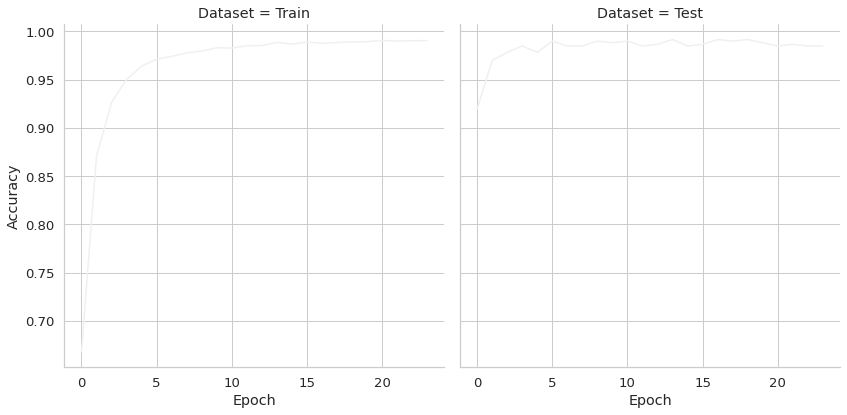

In [14]:
plot_experiments(df_balan_128)

F1 Score : 0.9925446774388174
Precision: 0.9926244380609248
Recall   : 0.9925923344837612


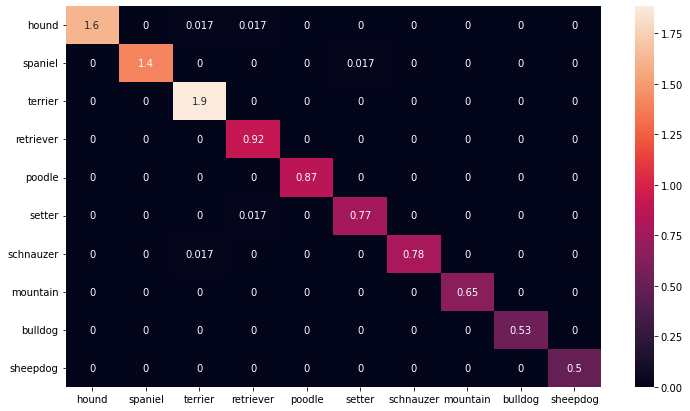

In [8]:
from utils import load_checkpoint, eval_test_accuracy, show_confusion_matrix, show_eval_metrics

net = EfficientNet().to(device)
load_checkpoint(net, "3f811cb6") # to be manually updated

mean, std = train_x.mean(), train_x.std()
accuracy, pred_y, true_y = eval_test_accuracy(net, mean, std, (test_x, test_y), (3, 128, 128), batch_size=25)

show_confusion_matrix(pred_y, true_y)
show_eval_metrics(pred_y, true_y)